### Aplicaciones de las Redes Recurrentes y de la Arquitectura Transformer a la Clasificación de Textos

#### *Descripción del Problema y Aplicación*

En este proyecto, se aborda el problema de clasificar preguntas de Stack Overflow en función de su calidad, utilizando un conjunto de datos de 60,000 preguntas titulado **"Stack Overflow Questions with Quality Rating"**. Este conjunto de datos contiene preguntas reales de la plataforma Stack Overflow, cada una acompañada de una calificación de calidad, que indica si la pregunta es de alta calidad o no.

El objetivo principal de esta aplicación es **desarrollar un modelo que pueda predecir automáticamente la calidad de nuevas preguntas**. Esto es crucial para comunidades como Stack Overflow, donde mantener un alto estándar de calidad es esencial para la utilidad y la colaboración efectiva entre los usuarios. Una herramienta de este tipo puede ayudar a:

- Filtrar automáticamente preguntas de baja calidad antes de que se publiquen.

- Sugerir mejoras o recomendaciones a los usuarios que formulan preguntas.

- Proporcionar retroalimentación valiosa para moderadores y editores.

Para lograr esto, se están utilizando técnicas avanzadas de **procesamiento de lenguaje natural (NLP)** y modelos de redes neuronales basados en BERT, junto con arquitecturas como LSTM y CNN. Estos modelos permiten comprender el contexto y el significado semántico de las preguntas, lo que es fundamental para determinar su calidad.

#### *Paso 1*: Obtención de los datos desde el repositorio de Github

In [1]:
# Desinstalar versiones que no sean compatibles
!pip uninstall -y tensorflow keras transformers
!pip install tensorflow==2.18.0 keras>=3.8.0 transformers==4.52.2

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: transformers 4.52.2
Uninstalling transformers-4.52.2:
  Successfully uninstalled transformers-4.52.2


In [2]:
import io
import os
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import transformers

In [3]:
GITHUB_RAW_REPOSITORY = "https://raw.githubusercontent.com/DCajiao/Text-classification-with-recurrent-networks-and-transformers/refs/heads/main/"
TRAIN_DATA_PATH = "data/train/train.csv"
TEST_DATA_PATH = "data/test/test.csv"


def download_content(dataframe_name):
    dataframes_urls = {
    "train": f"{GITHUB_RAW_REPOSITORY}{TRAIN_DATA_PATH}",
    "test": f"{GITHUB_RAW_REPOSITORY}{TEST_DATA_PATH}"
    }

    try:
        url = dataframes_urls[dataframe_name]
        response = requests.get(url)

        if response.status_code == 200:
            df = pd.read_csv(io.StringIO(response.text))
            if not os.path.exists("data"):
                os.makedirs("data")
            df.to_csv(f"data/{dataframe_name}.csv", index=False)

            return df
        else:
            raise Exception(f"Failed to download {dataframe_name} data: {response.status_code}")
    except Exception as e:
        print(f"Error downloading {dataframe_name} data: {e}")
        return None

In [4]:
df_train = download_content("train")
df_test = download_content("test")

#### *Paso 2*: Análisis Exploratorio de Datos

In [5]:
def summary_by_columns(df):
    """
    Generates a summary of each column in the provided DataFrame.

    The summary includes the data type, number of missing values, number of unique values,
    and number of duplicate values for each column.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the summary information for each column.
    """
    # Create an empty DataFrame to store the summary
    summary_df = pd.DataFrame(
        columns=['Column', 'Data Type', 'Missing Values', 'Unique Values', 'Duplicates'])

    # Loop through each column in the DataFrame
    for col in df.columns:
        data_type = df[col].dtype
        missing_values = df[col].isna().sum()
        num_unique_values = df[col].nunique()
        num_duplicates = df[col].duplicated().sum()

        # Add the results to the summary DataFrame
        row_summary = pd.DataFrame({
            'Column': [col],
            'Data Type': [data_type],
            'Missing Values': [missing_values],
            'Unique Values': [num_unique_values],
            'Duplicates': [num_duplicates],
            'Missing Values (%)': [round((missing_values / df.shape[0]) * 100, 2)]
        })

        # Concatenate the row summary to the summary DataFrame
        summary_df = pd.concat([summary_df, row_summary], ignore_index=True)

    return summary_df

In [6]:
# Crearé un df_full para analizar los datos de entrenamiento y test y sobre él aplicaré la función summary_by_columns
df_full = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
# Resumen general de todo el DataFrame combinado
print("Resumen general del DataFrame combinado:")
summary_by_columns(df_full)

Resumen general del DataFrame combinado:


,Column,Data Type,Missing Values,Unique Values,Duplicates,Missing Values (%)
0,Id,int64,0,60000,0,0.0
1,Title,object,0,59995,5,0.0
2,Body,object,0,60000,0,0.0
3,Tags,object,0,33224,26776,0.0
4,CreationDate,object,0,59981,19,0.0
5,Y,object,0,3,59997,0.0


In [8]:
print("Entrenamiento: ", df_train.shape)
print("Validación: ", df_test.shape)

Entrenamiento:  (45000, 6)
Validación:  (15000, 6)


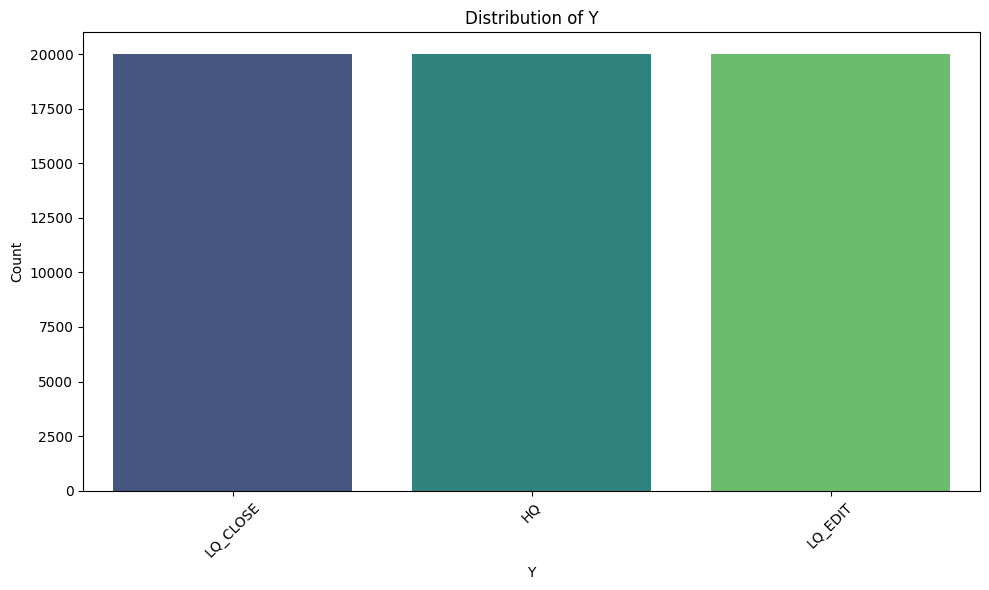

In [9]:
# ¿Las clases están balanceadas?
def plot_class_distribution(df, column_name):
    """
    Plots the distribution of classes in a specified column of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data.
    column_name : str
        The name of the column to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name, palette='viridis', hue='Y')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    # Show the tags
    plt.tight_layout()
    plt.show()


plot_class_distribution(df_full, 'Y')

Recordemos que el significado de clada clase es el siguiente:

- `HQ`: Mensajes de alta calidad sin una sola edición.
- `LQ_EDIT`: Mensajes de baja calidad con una puntuación negativa y múltiples ediciones de la comunidad. Sin embargo, siguen abiertos después de esos cambios.
- `LQ_CLOSE`: Mensajes de baja calidad que fueron cerrados por la comunidad sin una sola edición.

### *Paso 3*: Transformaciones, Codificación y Tokenización

In [10]:
df_full[['Title', 'Body']].head()

,Title,Body
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou..."
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...


In [11]:
# Dado que ambos campos son texto, voy a unirlos como un solo campo de texto tanto para el entrenamiento como para la prueba.
df_train['Full_text'] = df_train['Title'] + ' ' + df_train['Body']
df_test['Full_text'] = df_test['Title'] + ' ' + df_test['Body']

# Ahora esta columna 'Full_text' contendrá el texto completo de cada entrada, combinando el título y el cuerpo.
# Sin embargo, aún tiene etiquetas html, de manera que voy a eliminar las etiquetas html de los textos.

df_train["Full_text"] = df_train["Full_text"].str.replace(r'<.*?>', '', regex=True).str.lower()
df_test["Full_text"] = df_test["Full_text"].str.replace(r'<.*?>', '', regex=True).str.lower()

# Además, eliminaré el resto de columnas que no son necesarias para el análisis.
df_train = df_train.drop(columns=["Id","Title", "Body","Tags","CreationDate"])
df_test = df_test.drop(columns=["Id","Title", "Body","Tags","CreationDate"])


In [12]:
import joblib
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder

In [13]:
# Codificación de etiquetas solo con train
encoder = LabelEncoder()
df_train["Y"] = encoder.fit_transform(df_train["Y"])
df_test["Y"] = encoder.transform(df_test["Y"])

# Guardar el encoder
joblib.dump(encoder, "encoder.joblib")

['encoder.joblib']

### *Paso 4*: Experimentación con modelos

In [14]:
import joblib

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, Input, LSTM, Dense, Dropout, Layer, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.saving import register_keras_serializable

# Carpeta de Modelos
if not os.path.exists("./models"):
   os.makedirs("./models")

##### Modelo 1: LSTM - BERT

In [15]:
# 1. Tokenizer y ajuste
tokenizer_keras = Tokenizer()
tokenizer_keras.fit_on_texts(df_train["Full_text"])

# 2. Convertir textos a secuencias de enteros
X_train_seq = tokenizer_keras.texts_to_sequences(df_train["Full_text"])
X_test_seq = tokenizer_keras.texts_to_sequences(df_test["Full_text"])

# 3. Padding
max_len = 128
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

# 4. Vocabulario
vocab_size = len(tokenizer_keras.word_index) + 1

# 5. Etiquetas
y_train = df_train["Y"].values
y_test = df_test["Y"].values

num_classes = len(set(y_train))

# 6. Modelo
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
embedding_dim = 128
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_ids)
x = LSTM(128, return_sequences=True)(embedding_layer)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation="softmax")(x)

model_lstm_puro = Model(inputs=input_ids, outputs=output)
model_lstm_puro.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_lstm_puro.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │    23,754,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,886,467 (91.12 MB)

 Trainable params: 23,886,467 (91.12 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks para LSTM
early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,           # Más paciencia para LSTM
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_lstm = ModelCheckpoint(
    'models/best_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr_lstm = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # Reduce lr a la mitad
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Parámetros
EPOCHS_LSTM = 25
BATCH_SIZE_LSTM = 64
VALIDATION_SPLIT = 0.1

# 7. Entrenamiento
print("Iniciando entrenamiento LSTM...")
history_lstm_puro = model_lstm_puro.fit(
    x=X_train_pad,
    y=y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS_LSTM,
    batch_size=BATCH_SIZE_LSTM,
    callbacks=[early_stopping_lstm, model_checkpoint_lstm, reduce_lr_lstm],
    verbose=1
)

# 8. Guardar modelo
model_lstm_puro.save("models/modelo_lstm_puro.keras")
print("Modelo LSTM guardado exitosamente!")

Iniciando entrenamiento LSTM...
Epoch 1/25
632/633 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5070 - loss: 0.9553
Epoch 1: val_loss improved from inf to 0.75821, saving model to models/best_lstm_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.5074 - loss: 0.9549 - val_accuracy: 0.6547 - val_loss: 0.7582 - learning_rate: 2.0000e-04
Epoch 2/25
632/633 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7584 - loss: 0.5798
Epoch 2: val_loss did not improve from 0.75821
633/633 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7584 - loss: 0.5798 - val_accuracy: 0.6642 - val_loss: 0.7707 - learning_rate: 2.0000e-04
Epoch 3/25
631/633 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8240 - loss: 0.4481
Epoch 3: val_loss did not improve from 0.75821
633/633 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8240 - loss: 0.4481 - val_accuracy: 0.6378 - val_loss: 0.8685 - learning_rate: 2.0000e-04
Epoch 4/25
631/633 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8659 - loss:

In [17]:
print("\n=== Resumen de entrenamiento ===")
print(f"LSTM - Épocas completadas: {len(history_lstm_puro.history['loss'])}")
print(f"LSTM - Mejor val_loss: {min(history_lstm_puro.history['val_loss']):.4f}")
print(f"LSTM - Mejor val_accuracy: {max(history_lstm_puro.history['val_accuracy']):.4f}")


=== Resumen de entrenamiento ===
LSTM - Épocas completadas: 6
LSTM - Mejor val_loss: 0.7582
LSTM - Mejor val_accuracy: 0.6642


##### Modelo 2: Transformer - Bert

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from transformers import TFBertModel

In [19]:
# Tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )

train_encodings = tokenize_texts(df_train["Full_text"])
test_encodings = tokenize_texts(df_test["Full_text"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("bert-base-uncased")
        self.bert.trainable = True

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        return cls_output

    def compute_output_shape(self, input_shape):
        # input_shape is a list of tuples: [(batch_size, seq_len), (batch_size, seq_len)]
        batch_size = input_shape[0][0]
        hidden_size = self.bert.config.hidden_size
        return (batch_size, hidden_size)

In [21]:
# Parámetros
max_len = 128
num_classes = 3
dropout_rate = 0.3          # Probabilidad de dropout
l2_reg = 1e-4               # Regularización L

# Inputs
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Capa BERT custom
bert_output = BertLayer()([input_ids, attention_mask])

# Reducción de dimensionalidad + regularización
x = Dropout(dropout_rate)(bert_output)
x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = Dropout(dropout_rate)(x)

# Capa salida
output = Dense(num_classes, activation="softmax")(x)

# Modelo completo
model_bert_cls = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert_cls.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model_bert_cls.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 768)       │          0 │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     98,432 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        387 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,819 (386.01 KB)

 Trainable params: 98,819 (386.01 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping_bert = EarlyStopping(
    monitor='val_loss',
    patience=2,           # Menos paciencia para BERT (converge rápido)
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_bert = ModelCheckpoint(
    'models/best_bert_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr_bert = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,           # Reduce más rápido para BERT
    min_lr=1e-7,         # Menor learning rate mínimo
    verbose=1
)

# Parámetros
EPOCHS_BERT = 8
BATCH_SIZE_BERT = 16
VALIDATION_SPLIT = 0.1

print("Iniciando entrenamiento BERT...")
history_bert_cls = model_bert_cls.fit(
    x={
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    y=df_train["Y"].values,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS_BERT,
    batch_size=BATCH_SIZE_BERT,
    callbacks=[early_stopping_bert, model_checkpoint_bert, reduce_lr_bert],
    verbose=1
)

# Guardar modelo final BERT
model_bert_cls.save("models/modelo_bert_cls.keras")
print("Modelo BERT guardado exitosamente!")

Iniciando entrenamiento BERT...
Epoch 1/8
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3960 - loss: 1.1858
Epoch 1: val_loss improved from inf to 0.96756, saving model to models/best_bert_model.keras
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 331s 124ms/step - accuracy: 0.3961 - loss: 1.1858 - val_accuracy: 0.5162 - val_loss: 0.9676 - learning_rate: 2.0000e-05
Epoch 2/8
2531/2532 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5336 - loss: 0.9759
Epoch 2: val_loss improved from 0.96756 to 0.93863, saving model to models/best_bert_model.keras
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 309s 121ms/step - accuracy: 0.5336 - loss: 0.9759 - val_accuracy: 0.5491 - val_loss: 0.9386 - learning_rate: 2.0000e-05
Epoch 3/8
2531/2532 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5622 - loss: 0.9383
Epoch 3: val_loss improved from 0.93863 to 0.92254, saving model to models/best_bert_model.keras
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 322s 121ms/step - accuracy: 0.5622 - loss: 0.9383 - val_accuracy: 0.5556 - val_lo

In [23]:
print(f"\nBERT - Épocas completadas: {len(history_bert_cls.history['loss'])}")
print(f"BERT - Mejor val_loss: {min(history_bert_cls.history['val_loss']):.4f}")
print(f"BERT - Mejor val_accuracy: {max(history_bert_cls.history['val_accuracy']):.4f}")


BERT - Épocas completadas: 6
BERT - Mejor val_loss: 0.9001
BERT - Mejor val_accuracy: 0.5713


### *Paso 5*: Evaluación, Comparación de modelos y conclusiones

In [24]:
import numpy as np
import pandas as pd

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

In [25]:
# DICCIONARIO PARA GUARDAR LOS RESULTADOS DE LOS 2 MODELOS
resultados = {}

# NOMBRE DE LOS MODELOS
modelos_nombres = ['LSTM-BERT', 'TRANSFORMER-BERT']
modelos_paths = ['models/modelo_lstm_puro.keras', 'models/modelo_bert_cls.keras'] # best_lstm_model.keras , best_bert_model.keras

# TEST DATA
X_test = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}
y_test = df_test['Y'].values


In [32]:
# CARGAR Y EVALUAR CADA MODELO
for modelo_name, modelo_path in zip(modelos_nombres, modelos_paths):
    print(f"\n - Evaluando modelo: {modelo_name}")

    # Cargar el modelo
    modelo = tf.keras.models.load_model(modelo_path, compile=False, custom_objects={'BertLayer': BertLayer})

    # Predecir probabilidades con las entradas correctas
    if modelo_name == "LSTM-BERT" or modelo_name == "LSTM":
        # Modelos que usan la entrada paddeada
        y_probs = modelo.predict(X_test_pad, batch_size=16, verbose=1)
    elif modelo_name == "TRANSFORMER-BERT":
        # Modelos que usan la entrada BERT
        y_probs = modelo.predict({
            "input_ids": test_encodings["input_ids"],
            "attention_mask": test_encodings["attention_mask"]
        }, batch_size=16, verbose=1)

    # Obtener predicciones
    y_pred = np.argmax(y_probs, axis=1)

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    # Guardar resultados
    resultados[modelo_name] = {
        'y_pred': y_pred,
        'acc': acc,
        'report': report,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted,
        'y_probs': y_probs
    }

# RESUMEN DE F1 Y ACCURACY
df_summary = pd.DataFrame({
    'Modelo': modelos_nombres,
    'Accuracy': [resultados[m]['acc'] for m in modelos_nombres],
    'F1 Macro': [resultados[m]['f1_macro'] for m in modelos_nombres],
    'F1 Micro': [resultados[m]['f1_micro'] for m in modelos_nombres],
    'F1 Weighted': [resultados[m]['f1_weighted'] for m in modelos_nombres],
})
print("\n🔷 Resumen general de métricas:")
display(df_summary)



 - Evaluando modelo: LSTM-BERT
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

 - Evaluando modelo: TRANSFORMER-BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

938/938 ━━━━━━━━━━━━━━━━━━━━ 112s 116ms/step

🔷 Resumen general de métricas:


,Modelo,Accuracy,F1 Macro,F1 Micro,F1 Weighted
0,LSTM-BERT,0.688867,0.690746,0.688867,0.690746
1,TRANSFORMER-BERT,0.621667,0.618526,0.621667,0.618526


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


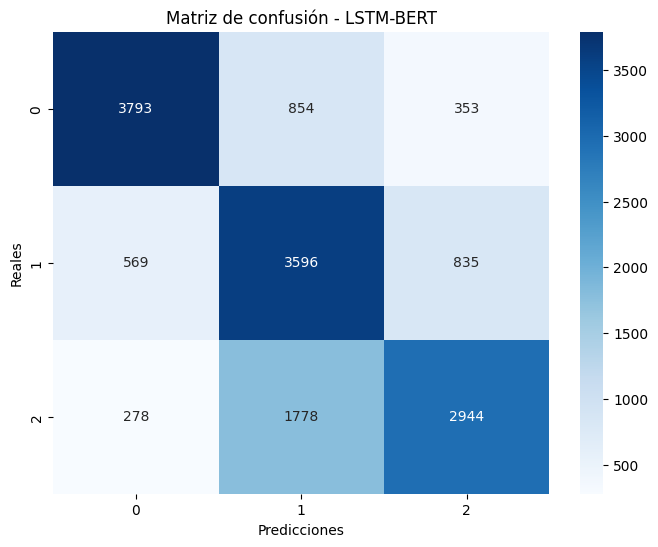


🔷 Reporte clasificación - LSTM-BERT:


,precision,recall,f1-score,support
0,0.817457,0.758600,0.786929,5000.000000
1,0.577392,0.719200,0.640542,5000.000000
2,0.712488,0.588800,0.644766,5000.000000
accuracy,0.688867,0.688867,0.688867,0.688867
macro avg,0.702446,0.688867,0.690746,15000.000000
weighted avg,0.702446,0.688867,0.690746,15000.000000


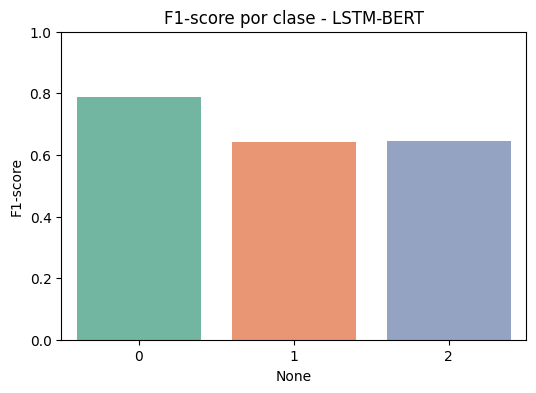

469/469 ━━━━━━━━━━━━━━━━━━━━ 120s 246ms/step


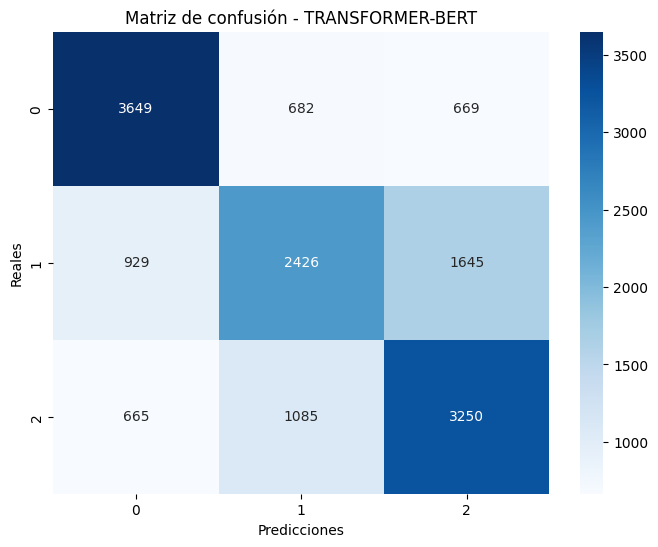


🔷 Reporte clasificación - TRANSFORMER-BERT:


,precision,recall,f1-score,support
0,0.695976,0.729800,0.712487,5000.000000
1,0.578583,0.485200,0.527793,5000.000000
2,0.584112,0.650000,0.615297,5000.000000
accuracy,0.621667,0.621667,0.621667,0.621667
macro avg,0.619557,0.621667,0.618526,15000.000000
weighted avg,0.619557,0.621667,0.618526,15000.000000


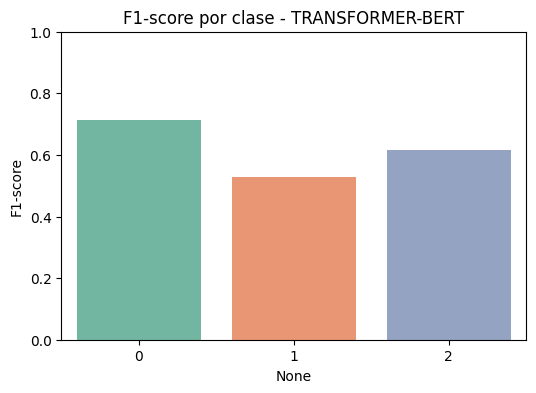

In [27]:
for modelo_name in modelos_nombres:
    # Generar las predicciones con el modelo real, en lugar de confiar en el 'y_pred' guardado
    if modelo_name == "LSTM-BERT":
        # Si es el modelo LSTM puro
        y_pred_prob = model_lstm_puro.predict(X_test_pad)
        y_pred = np.argmax(y_pred_prob, axis=1)
    elif modelo_name == "TRANSFORMER-BERT":
        # Si es el modelo BERT (asegúrate de que también has cargado ese modelo y encodings)
        y_pred_prob = model_bert_cls.predict({
            "input_ids": test_encodings["input_ids"],
            "attention_mask": test_encodings["attention_mask"]
        })
        y_pred = np.argmax(y_pred_prob, axis=1)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {modelo_name}")
    plt.xlabel("Predicciones")
    plt.ylabel("Reales")
    plt.show()

    # Reporte de clasificación
    print(f"\n🔷 Reporte clasificación - {modelo_name}:")
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    display(df_report)

    # F1-score por clase
    clases = df_report.iloc[:-3].index  # Omitimos avg/accuracy
    f1_scores = df_report.iloc[:-3]['f1-score']

    plt.figure(figsize=(6, 4))
    sns.barplot(x=clases, y=f1_scores, palette='Set2', hue=clases)
    plt.title(f"F1-score por clase - {modelo_name}")
    plt.ylabel("F1-score")
    plt.ylim(0, 1)
    plt.show()

In [33]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

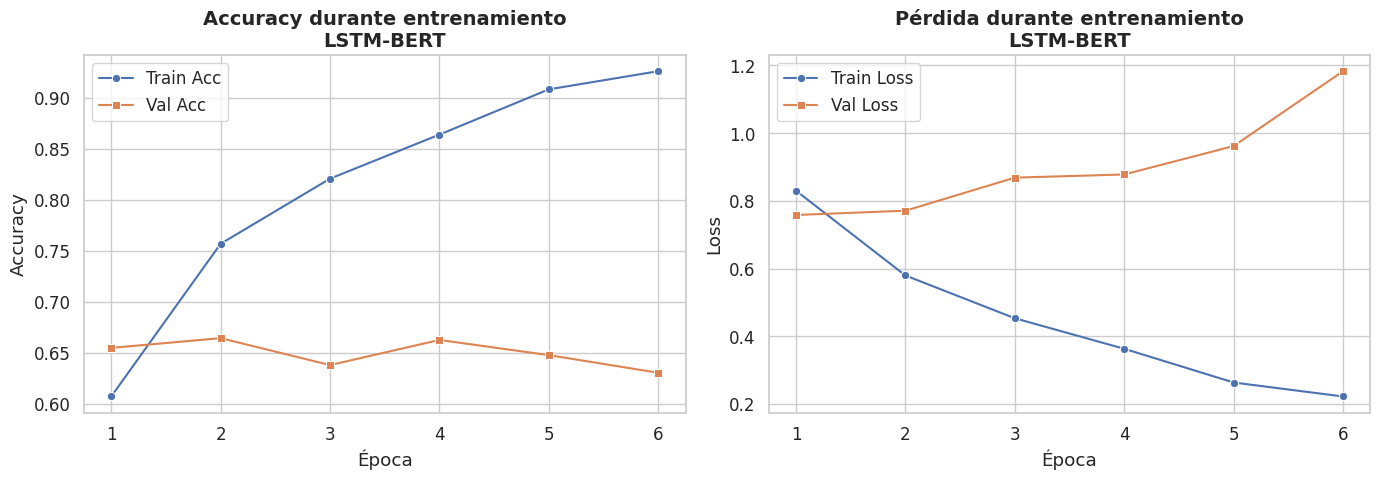

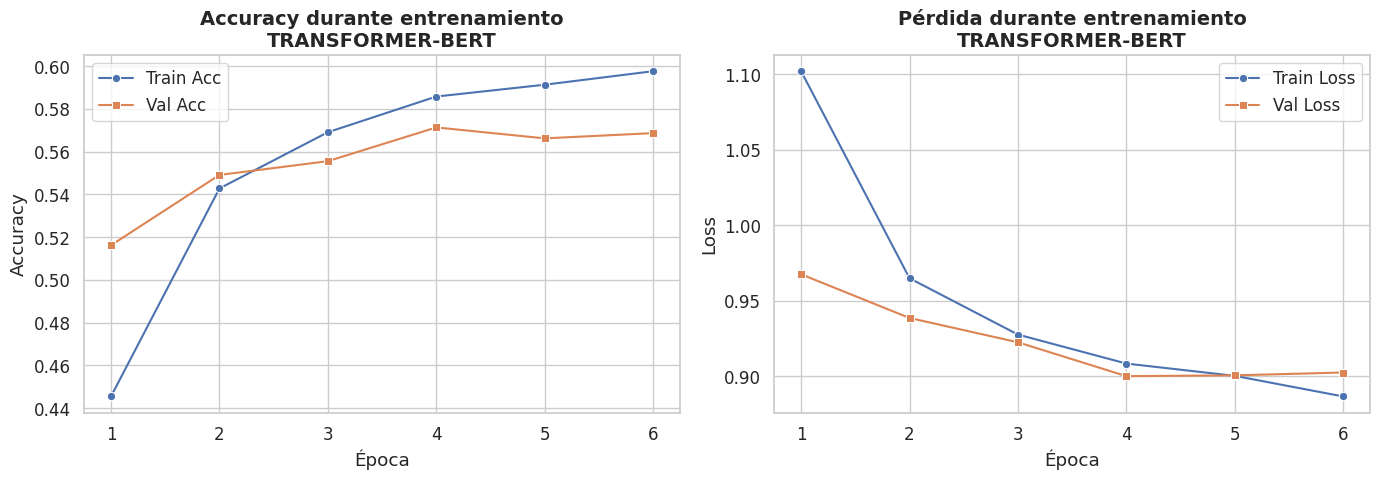

In [34]:
if not os.path.exists("training_history"):
  os.makedirs("training_history")

# Configuración de estilo de seaborn
sns.set(style="whitegrid", font_scale=1.1, palette="deep")

try:
    history_lstm = history_lstm_puro  # History del modelo LSTM-BERT
    history_bert = history_bert_cls   # History del modelo TRANSFORMER-BERT

    history_dict = {
        'LSTM-BERT': history_lstm,
        'TRANSFORMER-BERT': history_bert,
    }

    for modelo_name in modelos_nombres:
      # Guardar el history como un archivo JSON
      with open(f'training_history/{modelo_name}_history.json', 'w') as f:
          json.dump(history_dict[modelo_name].history, f)

      history = history_dict[modelo_name].history
      epochs = range(1, len(history['accuracy']) + 1)

      # Crear figura con dos subplots
      fig, axes = plt.subplots(1, 2, figsize=(14, 5))

      # Plot Accuracy en el primer subplot
      sns.lineplot(x=epochs, y=history['accuracy'], label='Train Acc', marker='o', ax=axes[0])
      sns.lineplot(x=epochs, y=history['val_accuracy'], label='Val Acc', marker='s', ax=axes[0])
      axes[0].set_title(f"Accuracy durante entrenamiento\n{modelo_name}", fontsize=14, weight='bold')
      axes[0].set_xlabel("Época")
      axes[0].set_ylabel("Accuracy")
      axes[0].legend()

      # Plot Loss en el segundo subplot
      sns.lineplot(x=epochs, y=history['loss'], label='Train Loss', marker='o', ax=axes[1])
      sns.lineplot(x=epochs, y=history['val_loss'], label='Val Loss', marker='s', ax=axes[1])
      axes[1].set_title(f"Pérdida durante entrenamiento\n{modelo_name}", fontsize=14, weight='bold')
      axes[1].set_xlabel("Época")
      axes[1].set_ylabel("Loss")
      axes[1].legend()

      plt.tight_layout()
      plt.show()


except NameError:
    print("No se encontraron historiales de entrenamiento para los modelos.")